# LoRA on MNIST  
This notebook will attempt to implement Low-Rank Adaptation(LoRA) Finetuning from scratch on the MNIST dataset using pytorch lightning. I'm purposely using a simple model and data that way I can focus on LoRA implementation. 

Plan
1. Build an MLP. Train this model to perform well on MNIST 0-4 (half of the data).
3. Use standard finetuning approach to train this model to work on MNIST 5-9 (this will act as our baseline)
4. Use LoRA finetuning to train the original model to work on MNIST 5-9
5. Compare finetuning techniques (performance, memory etc)

Other ideas:
- LoRA from 1/2 of the dataset to the entire thing (replicates "change of data" a bit more)
- try to FT as "quickly as possible" (fewest epochs/steps)

Sources:
1. https://arxiv.org/abs/2106.09685
2. https://lightning.ai/pages/community/tutorial/lora-llm/ - (The first half offers useful starter pseudocode)
3. https://colab.research.google.com/drive/1iERDk94Jp0UErsPf7vXyPKeiM4ZJUQ-a?usp=sharing#scrollTo=WuK0lPwcB7Ia - had some good ideas on metrics to compute about LoRA-ized model
4. https://lightning.ai/docs/pytorch/stable/notebooks/lightning_examples/mnist-hello-world.html - starter code for building an MLP and training on MNIST
5. https://discuss.pytorch.org/t/how-to-use-one-class-of-number-in-mnist/26276/21 - forum post on how to limit MNIST to only first or second half


https://chat.openai.com/share/3b640063-3ce0-4373-bdad-59503a434a28

In [1]:
# reserved for imports

import lightning as L
from lightning.pytorch.loggers import CSVLogger

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

from torchmetrics import Accuracy

import pandas as pd
import seaborn as sn

# make results reproducable
L.seed_everything(42)

Global seed set to 42


42

In [2]:
# reserved for constants
PATH_DATASETS = '/home/sunil/lora_from_scratch/data'


# Step 1: Train an MLP on the first half of MNIST

In [3]:
# we need to split MNIST training data into 
from torch.utils.data import Dataset
class custom_subset(Dataset):
    r"""
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
        labels(sequence) : targets as required for the indices. will be the same length as indices
    """
    def __init__(self, dataset, indices, labels):
        self.dataset = torch.utils.data.Subset(dataset, indices)
        self.targets = labels
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        target = self.targets[idx]
        return (image, target)

    def __len__(self):
        return len(self.targets)

In [4]:
class LitMNIST(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, lr=2e-4):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.lr = lr

        # Hardcode some dataset specific attributes
        self.class_names = [0,1,2,3,4]
        self.min_class = min(self.class_names)
        self.num_classes = len(self.class_names) 
        self.dims = (1, 28, 28) # the shape of an example (C x W x H)
        channels, width, height = self.dims

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.batch_size = 256

        # Define layers for model
        self.l1 = nn.Linear(channels * width * height, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, self.num_classes)

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

        
        # Define metrics
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)


    def forward(self, x):
        # preprocessing
        x = torch.flatten(x,1)

        # layer 1 (input size, hidden size)
        x = self.l1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # layer 2 (hidden size, hidden size)
        x = self.l2(x)
        x = self.relu(x)
        x = self.dropout(x)

        #layer 3 (hidden size, self.num_classes)
        x = self.l3(x)
                    
        # notice that we return the log probabilities here as that is what nll loss expects in the training step
        return F.log_softmax(x, dim=1)

    def common_step(self, batch, batch_idx):
        # define steps all of {train, val, test} will take in one place
        x, y = batch
        # rescale y to be 0 indexed if necessary (like when we start using mnist 5-9)
        if self.min_class != 0:
            y = y - self.min_class
        
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return x,y, logits, loss
        
        

    def training_step(self, batch, batch_idx):
        _, _, _, loss = self.common_step(batch, batch_idx)
        return loss

    def validation_step(self, batch, batch_idx):
        
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
    
    def configure_optimizers(self):
        # we'll use adam for simplicity
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    # the rest of the class is helper functions/hooks for configuring data/dataloader building
    @staticmethod
    def get_indices(dataset,class_names):
        if isinstance(dataset, torch.utils.data.dataset.Subset):
            targets = torch.tensor([dataset.dataset.targets[i] for i in dataset.indices])
        else:
            targets = dataset.targets

            
        indices =  []
        for i in range(len(targets)):
            if targets[i] in class_names:
                indices.append(i)
        return indices
        
    def create_dataloader(self,dataset):
        idx = self.get_indices(dataset, self.class_names)
        loader = DataLoader(dataset,batch_size=self.batch_size, sampler = SubsetRandomSampler(idx), num_workers=16) # Note - this necessarily shuffles the data due to the sampler we are using
        return loader

    def prepare_data(self):
        # download data
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

            

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)


    def train_dataloader(self):
        return self.create_dataloader(self.mnist_train)

    def val_dataloader(self):
        return self.create_dataloader(self.mnist_val)

    def test_dataloader(self):
        return self.create_dataloader(self.mnist_test)

        
        

        


In [5]:
model = LitMNIST()
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 325   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
---

Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 110/110 [00:03<00:00, 33.67it/s, v_num=59]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|███████████████████████████████████| 110/110 [00:03<00:00, 32.80it/s, v_num=59, val_loss=0.232, val_acc=0.936]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|███████████████████████████████████| 110/110 [00:03<00:00, 33.23it/s, v_num=59, val_loss=0.154, val_acc=0.954]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|███████████████████████████████████| 110/110 [00:03<00:00, 32.27it/s, v_num=59, val_loss=0.133, val_acc=0.961]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|███████████████████████████████████| 110/110 [00:03<00:00, 32.52it/s, v_num=59, val_loss=0.120, val_acc=0.962]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|███████████████████████████████████| 110/110 [00:03<00:00, 32.99it/s, v_num=59, val_loss=0.110, val_acc=0.963]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|███████████████████████████████████| 110/110 [00:0

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████| 110/110 [00:04<00:00, 25.16it/s, v_num=59, val_loss=0.0747, val_acc=0.974]


,val_loss,val_acc
epoch,,
0,0.231902,0.935938
1,0.154334,0.953516
2,0.132763,0.960938
3,0.120435,0.962109
4,0.110189,0.962891


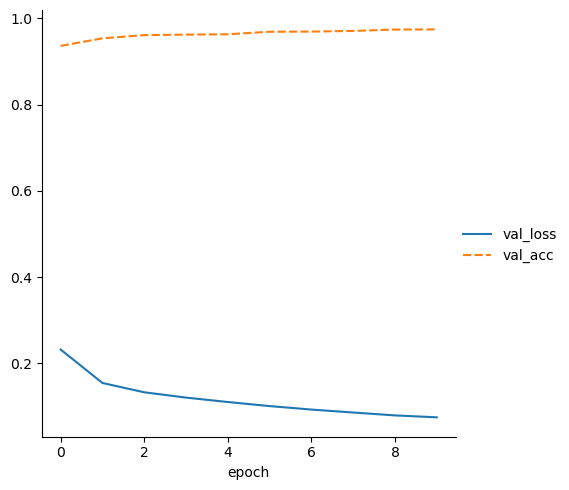

In [6]:

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [7]:
# as expected our model performs well, achieving 98% test accuracy
trainer.test()

/home/sunil/miniconda3/envs/lora_from_scratch/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/lightning_logs/version_59/checkpoints/epoch=9-step=1100.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoi

Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 492.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9850165247917175     │
│         test_loss         │   0.050125159323215485    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.050125159323215485, 'test_acc': 0.9850165247917175}]

In [8]:
# save model weights so we can finetune from them later
trainer.save_checkpoint("model.ckpt")

# Finetune on second half of MNIST

In [9]:
# load the model - we refer to it as "no training" as we are going to use this initialization to show that the model performs poorly on the second half of mnist (as it wasn't trained on it)
model_loaded_no_training = LitMNIST.load_from_checkpoint(checkpoint_path="model.ckpt")

In [10]:
# set it up to run on the second half of mnist (digits 5,6,7,8,9)
model_loaded_no_training.class_names= [5,6,7,8,9]
model_loaded_no_training.min_class = min(model_loaded_no_training.class_names)

In [11]:
# we will train on the new data on exactly one element once (this is so we can access the trainer2.test() function, which allows us to easily evaluate how well our model works on the new data prior to training)
model_loaded_no_training.batch_size = 1
trainer_no_train = L.Trainer(
    accelerator="auto",
    devices=1,
    max_steps=1,
    logger=CSVLogger(save_dir="logs/"),
)
trainer_no_train.fit(model_loaded_no_training)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 325   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
---

Epoch 0:   0%|                                                                | 1/26895 [00:00<5:17:40,  1.41it/s, v_num=60]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0:   0%|                                                                | 1/26895 [00:00<5:19:22,  1.40it/s, v_num=60]


In [12]:
# we can see our model performs extremely poorly on the new data (34% accuracy), which is unsuprising. 
trainer_no_train.test()

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/lightning_logs/version_60/checkpoints/epoch=0-step=1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/lightning_logs/version_60/checkpoints/epoch=0-step=1.ckpt


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 4861/4861 [00:08<00:00, 606.06it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.34211066365242004    │
│         test_loss         │    3.2421905994415283     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 3.2421905994415283, 'test_acc': 0.34211066365242004}]

In [13]:
# now finetune e2e on the new data
model_5_9 = LitMNIST.load_from_checkpoint(checkpoint_path="model.ckpt")
# set it up to run on the second half of mnist (digits 5,6,7,8,9)
model_loaded_no_training.class_names= [5,6,7,8,9]
model_loaded_no_training.min_class = min(model_loaded_no_training.class_names)

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model_5_9)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 50.2 K
1 | l2            | Linear             | 4.2 K 
2 | l3            | Linear             | 325   
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
---

Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 110/110 [00:03<00:00, 33.44it/s, v_num=61]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████████████████████████████| 110/110 [00:03<00:00, 33.39it/s, v_num=61, val_loss=0.0565, val_acc=0.981]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████████████████████████████| 110/110 [00:03<00:00, 32.49it/s, v_num=61, val_loss=0.0515, val_acc=0.985]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████████████████████████████| 110/110 [00:03<00:00, 32.24it/s, v_num=61, val_loss=0.0513, val_acc=0.984]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████████████████████████████| 110/110 [00:03<00:00, 32.39it/s, v_num=61, val_loss=0.0484, val_acc=0.985]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████████████████████████████| 110/110 [00:03<00:00, 32.60it/s, v_num=61, val_loss=0.0459, val_acc=0.985]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████████████████████████████| 110/110 [00:03

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████| 110/110 [00:04<00:00, 25.73it/s, v_num=61, val_loss=0.0389, val_acc=0.987]


In [14]:
# unsuprisingly finetuning allows us to perform equally well on the second half of MNIST. However this approach would require us to save the entire model binary for each dataset we wanted to finetune our initial model on, which doesn't scale well.
trainer.test()

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/lightning_logs/version_61/checkpoints/epoch=9-step=1100.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/lightning_logs/version_61/checkpoints/epoch=9-step=1100.ckpt


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 394.16it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9896867275238037     │
│         test_loss         │   0.028699563816189766    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.028699563816189766, 'test_acc': 0.9896867275238037}]

# Finetune on second half of MNIST using LoRA